# Fig. 6 - Properties of spontaneous and evoked events in the rate model with noise.

Here we have a noisy input mimicking synaptic current updates are injected to each rate-model population (see paper for more details). The noise is modelled as a Poisson-distributed spikes convoluted with synaptic kernel.

In [1]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from chspy import join
from neurolib.models.multimodel import MultiModel
from neurolib.utils.stimulus import StepInput, ZeroInput
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt, find_peaks, peak_widths
from scipy.stats import pearsonr

from hippocampus import HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY, HippocampalCA3Node
from model_input import PeriodicRandomSquareInput
from utils import AnchoredHScaleBar

plt.style.use("default_light")

## Helper functions and constants
- `simulate_hc_spontaneous`: integrates the model with noise for a given time (long simulations, ~ 10 minutes, to get the statistics of SWR events), no stimulation here
- `detect_peaks`: simple peak detector. Peaks are SWR events and these are detected on the low-pass filtered output from the B population
- `fit_func`: exponential function used for fitting the relationship of SWR amplitude and previous inter event interval

In [29]:
DT = 0.05
SAMPLING_DT = 0.5
HIGH_FILT_THRESH = 10.0  # Hz
PEAK_HEIGHT = 0.045  # kHz
PEAK_DIST = 100.0  # ms


def simulate_hc_spontaneous(duration=60, backend="numba"):
    hc = HippocampalCA3Node(constant_depression=False)
    m = MultiModel.init_node(hc)
    m.model_instance.initial_state = np.array([0.0001, 0.003, 0.012, 0.649])
    m.params["backend"] = backend
    m.params["duration"] = duration * 1e3
    m.params["dt"] = DT
    m.params["sampling_dt"] = SAMPLING_DT
    # pyr_inp, pv_inp, aswr_inp = m.model_instance.noise_input
    # if backend == "numba":
    #     noise_input = np.hstack(
    #         [
    #             noise.as_array(duration * 1e3, DT)
    #             for noise in [pyr_inp, pv_inp, aswr_inp]
    #         ]
    #     ).T
    #     assert noise_input.shape[0] == 3
    m.run()
    return m.xr()


def simulate_hc_evoked(
    duration=60,
    pulse_amp=150.0,
    pulse_duration=10.0,
    pulse_period=2000.0,
    backend="numba",
):
    hc = HippocampalCA3Node(constant_depression=False)
    m = MultiModel.init_node(hc)
    m.model_instance.initial_state = np.array([0.0001, 0.003, 0.012, 0.649])
    m.params["backend"] = backend
    m.params["duration"] = duration * 1e3
    m.params["dt"] = DT
    m.params["sampling_dt"] = SAMPLING_DT
    # manually init noise input (w. stimulation)
    pv_stimulation = PeriodicRandomSquareInput(
        step_size=pulse_amp,
        step_duration=pulse_duration,
        step_period=pulse_period,
        max_jitter=90,
    )
    pyr_inp, pv_inp, aswr_inp = m.model_instance.noise_input
    if backend == "numba":
        noise_input = np.hstack(
            [
                noise.as_array(duration * 1e3, DT)
                for noise in [pyr_inp, pv_inp, aswr_inp]
            ]
        ).T
        assert noise_input.shape[0] == 3
        noise_input[1, :] += pv_stimulation.as_array(duration * 1e3, DT).squeeze()
        stim_time_idx = find_stim_starts(
            noise_input[1, :], threshold=pulse_amp / 2, stim_length=pulse_duration / DT
        )
    elif backend == "jitcdde":
        raise NotImplementedError
    m.run(noise_input=noise_input)
    return m.xr(), stim_time_idx, noise_input


def find_stim_starts(stim_ts, threshold, stim_length):
    idx = 0
    peaks = []
    while idx < stim_ts.shape[0]:
        if stim_ts[idx] > threshold:
            peaks.append(idx)
            idx += int(stim_length * 1.15)
        else:
            idx += 1
    return peaks


def detect_peaks(ts, time_vec):
    # low-pass filter
    nyq = 0.5 * (1e3 / SAMPLING_DT)
    high = HIGH_FILT_THRESH / nyq
    b_filt, a_filt = butter(2, high, btype="low", analog=False)
    lowpass_sig = filtfilt(b_filt, a_filt, ts)
    # detect peaks
    pks, _ = find_peaks(
        lowpass_sig,
        height=PEAK_HEIGHT,
        distance=int(PEAK_DIST / SAMPLING_DT),
    )
    # peak widths - FWHM
    widths = peak_widths(lowpass_sig, pks, rel_height=0.5)[0]
    # indices of start and end
    peaks_start = (pks - widths // 2).astype(int)
    peaks_end = (pks + widths // 2).astype(int)
    durations = time_vec[peaks_end] - time_vec[peaks_start]
    amplitudes = lowpass_sig[pks]
    # discard first start and last end and then subtract
    inter_event_interval = time_vec[peaks_start][1:] - time_vec[peaks_end][:-1]

    return pks, inter_event_interval, amplitudes, widths


def fit_func(x, a, b, c):
    return a * (1.0 - np.exp(-b * x)) + c

## Compute and plot spontaneous

We run 10 minutes simulation and detect **spontaneous** SWR events. SWR events are detected on low-passed output of the B population (i.e. low-passed firing rate of PV$^{+}$ basket cells) and plot the excerpt of the timeseries and SWR statistics: the distribution of inter event intervals (IEI), and relationship between previous IEI and SWR amplitude and next IEI and SWR amplitude.

Found 589 events in total
Smallest IEI: 58.0ms
IEI: 0.940 +- 0.664s
amplitudes: 0.092 +- 0.005kHz
FWHM: 79.566 +- 6.364ms
Corr. amp. vs. previous IEI: 0.445 / p=0.00000
Corr. amp. vs. next IEI: 0.001 / p=0.97932
Time constant of fit: 145.379 ms


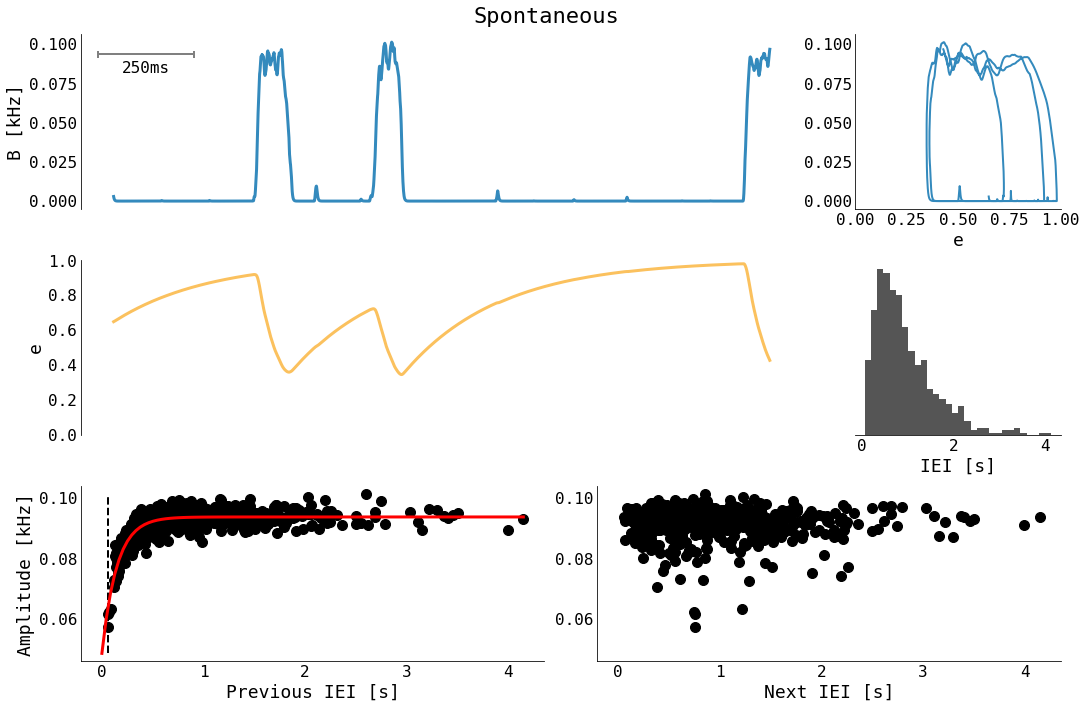

In [30]:
# simulate 10 minutes
res = simulate_hc_spontaneous(duration=600, backend="numba")

peaks, iei, amps, fwhms = detect_peaks(
    res.sel({"output": "r_mean_INH"}).squeeze().values, res.time.values
)
# find 2 seconds with at least 3 peaks
rolling_sum_iei = np.cumsum(iei)
rolling_sum_iei[2:] = rolling_sum_iei[2:] - rolling_sum_iei[:-2]
rolling_sum_iei = rolling_sum_iei[1:]
at_least_3peaks = np.where(rolling_sum_iei < 1.8)[0][0]
mid_point = peaks[at_least_3peaks + 1] * SAMPLING_DT * 1e-3
res = res.sel({"time": slice(mid_point - 1.0, mid_point + 1.0)})

plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 4)
cols = ["C1", "C4"]
fields = ["r_mean_INH", "e_SynDep"]
ylabels = ["B [kHz]", "e"]

for i in range(2):
    ax = plt.subplot(gs[i, :3])
    ax.plot(res.time, res.sel({"output": fields[i]}).T, color=cols[i], linewidth=3)
    ax.set_xticks([])
    ax.set_ylabel(ylabels[i])
    sns.despine(ax=ax, bottom=True)
    if i == 0:
        bar = AnchoredHScaleBar(
            size=0.25,
            label="250ms",
            loc=2,
            linekw=dict(color="gray", linewidth=2.0),
            ax=ax,
        )
        ax.add_artist(bar)
    if i == 1:
        ax.set_ylim([0, 1])

# phase plane B-e
ax = plt.subplot(gs[0, -1])
ax.plot(
    res.sel({"output": "e_SynDep"}).T, res.sel({"output": "r_mean_INH"}).T, color=cols[0]
)
ax.set_xlim([0, 1])
ax.set_xlabel("e")
sns.despine(ax=ax)

# IEI
ax = plt.subplot(gs[1, -1])
ax.hist(iei, bins=30, fc="#555555")
sns.despine(ax=ax, left=True)
ax.set_yticks([])
ax.set_xlabel("IEI [s]")
hist_xlims = ax.get_xlim()


# SWR amp vs. IEI
ax = plt.subplot(gs[2, :2])
ax.plot(iei, amps[1:], "o", color="k")
# fit
fit_params, _ = curve_fit(
    fit_func, iei, amps[1:], p0=(2, 2, 68), bounds=(0, [100, 100, 100])
)
fit_iei = np.linspace(0, iei.max(), 100)
amps_fit = fit_func(fit_iei, *fit_params)
ax.plot(fit_iei, amps_fit, color="red", linewidth=3)
ax.vlines(iei.min(), amps_fit.min(), amps.max(), linestyles="--", color="k")
ax.set_xlabel("Previous IEI [s]")
ax.set_ylabel("Amplitude [kHz]")
sns.despine(ax=ax)
fit_xlim = ax.get_xlim()

ax = plt.subplot(gs[2, 2:], sharey=ax, sharex=ax)
ax.plot(iei, amps[:-1], "o", color="k")
ax.set_xlabel("Next IEI [s]")
sns.despine(ax=ax)
ax.set_xlim(fit_xlim)

plt.suptitle("Spontaneous")
plt.tight_layout()

plt.savefig("../figs/rate_spontaneous_SWR.pdf", transparent=True, bbox_inches="tight")

print(f"Found {len(peaks)} events in total")
print(f"Smallest IEI: {iei.min()*1e3:.1f}ms")
print(f"IEI: {np.mean(iei):.3f} +- {np.std(iei):.3f}s")
print(f"amplitudes: {np.mean(amps):.3f} +- {np.std(amps):.3f}kHz")
fwhms *= SAMPLING_DT
print(f"FWHM: {np.mean(fwhms):.3f} +- {np.std(fwhms):.3f}ms")
corr = pearsonr(iei, amps[1:])
print(f"Corr. amp. vs. previous IEI: {corr[0]:.3f} / p={corr[1]:.5f}")
corr = pearsonr(iei, amps[:-1])
print(f"Corr. amp. vs. next IEI: {corr[0]:.3f} / p={corr[1]:.5f}")
print(f"Time constant of fit: {1e3/fit_params[1]:.3f} ms")

## Repeat spontaneous for `jitcdde` backend

Found 113 events in total
Smallest IEI: 107.3ms
IEI: 0.988 +- 0.738s
amplitudes: 0.092 +- 0.005kHz
FWHM: 79.002 +- 5.926ms
Corr. amp. vs. previous IEI: 0.322 / p=0.00054
Corr. amp. vs. next IEI: 0.026 / p=0.78708
Time constant of fit: 117.586 ms


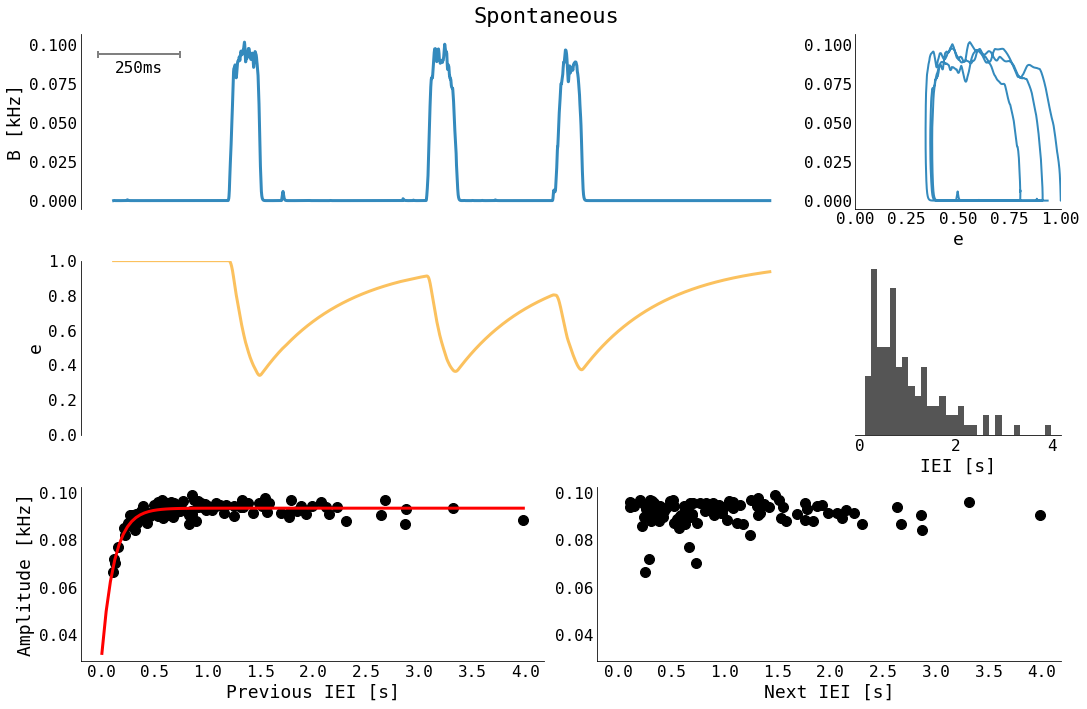

In [5]:
# simulate 2 minutes due to computational time
res = simulate_hc_spontaneous(duration=120, backend="jitcdde")

peaks, iei, amps, fwhms = detect_peaks(
    res.sel({"output": "r_mean_INH"}).squeeze().values, res.time.values
)
# find 2 seconds with at least 3 peaks
rolling_sum_iei = np.cumsum(iei)
rolling_sum_iei[2:] = rolling_sum_iei[2:] - rolling_sum_iei[:-2]
rolling_sum_iei = rolling_sum_iei[1:]
at_least_3peaks = np.where(rolling_sum_iei < 1.8)[0][0]
mid_point = peaks[at_least_3peaks + 1] * SAMPLING_DT * 1e-3
res = res.sel({"time": slice(mid_point - 1.0, mid_point + 1.0)})

plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 4)
cols = ["C1", "C4"]
fields = ["r_mean_INH", "e_SynDep"]
ylabels = ["B [kHz]", "e"]

for i in range(2):
    ax = plt.subplot(gs[i, :3])
    ax.plot(res.time, res.sel({"output": fields[i]}).T, color=cols[i], linewidth=3)
    ax.set_xticks([])
    ax.set_ylabel(ylabels[i])
    sns.despine(ax=ax, bottom=True)
    if i == 0:
        bar = AnchoredHScaleBar(
            size=0.25,
            label="250ms",
            loc=2,
            linekw=dict(color="gray", linewidth=2.0),
            ax=ax,
        )
        ax.add_artist(bar)
    if i == 1:
        ax.set_ylim([0, 1])

# phase plane B-e
ax = plt.subplot(gs[0, -1])
ax.plot(
    res.sel({"output": "e_SynDep"}).T, res.sel({"output": "r_mean_INH"}).T, color=cols[0]
)
ax.set_xlim([0, 1])
ax.set_xlabel("e")
sns.despine(ax=ax)

# IEI
ax = plt.subplot(gs[1, -1])
ax.hist(iei, bins=30, fc="#555555")
sns.despine(ax=ax, left=True)
ax.set_yticks([])
ax.set_xlabel("IEI [s]")

# SWR amp vs. IEI
ax = plt.subplot(gs[2, :2])
ax.plot(iei, amps[1:], "o", color="k")
# fit
fit_params, _ = curve_fit(
    fit_func, iei, amps[1:], p0=(2, 2, 68), bounds=(0, [100, 100, 100])
)
fit_iei = np.linspace(0, iei.max(), 100)
ax.plot(fit_iei, fit_func(fit_iei, *fit_params), color="red", linewidth=3)
ax.set_xlabel("Previous IEI [s]")
ax.set_ylabel("Amplitude [kHz]")
sns.despine(ax=ax)

ax = plt.subplot(gs[2, 2:], sharey=ax, sharex=ax)
ax.plot(iei, amps[:-1], "o", color="k")
ax.set_xlabel("Next IEI [s]")
sns.despine(ax=ax)

plt.suptitle("Spontaneous")
plt.tight_layout()

print(f"Found {len(peaks)} events in total")
print(f"Smallest IEI: {iei.min()*1e3:.1f}ms")
print(f"IEI: {np.mean(iei):.3f} +- {np.std(iei):.3f}s")
print(f"amplitudes: {np.mean(amps):.3f} +- {np.std(amps):.3f}kHz")
fwhms *= SAMPLING_DT
print(f"FWHM: {np.mean(fwhms):.3f} +- {np.std(fwhms):.3f}ms")
corr = pearsonr(iei, amps[1:])
print(f"Corr. amp. vs. previous IEI: {corr[0]:.3f} / p={corr[1]:.5f}")
corr = pearsonr(iei, amps[:-1])
print(f"Corr. amp. vs. next IEI: {corr[0]:.3f} / p={corr[1]:.5f}")
print(f"Time constant of fit: {1e3/fit_params[1]:.3f} ms")

## Profit: spontaneous

We got same figures. Naturally, since this is noisy simulation, the spontaneous SWRs would be at different timestamps, but the statistics of SWR are the same (accounting for shorter `jitcdde` simulation).

All good.

## Compute and plot evoked

We run 10 minutes simulation and detect **evoked** SWR events. On top of the noisy input, B population is getting periodic stimulation (period ~2second with random max. 90ms jitter) of 150pA and length 10ms. Detection and all statistics are the same as before.

Found 769 events in total
Smallest IEI: 57.5ms
IEI: 0.701 +- 0.474s
amplitudes: 0.090 +- 0.006kHz
FWHM: 78.117 +- 6.863ms
Corr. amp. vs. previous IEI: 0.537 / p=0.00000
Corr. amp. vs. next IEI: 0.019 / p=0.76223
Time constant of fit: 127.266 ms


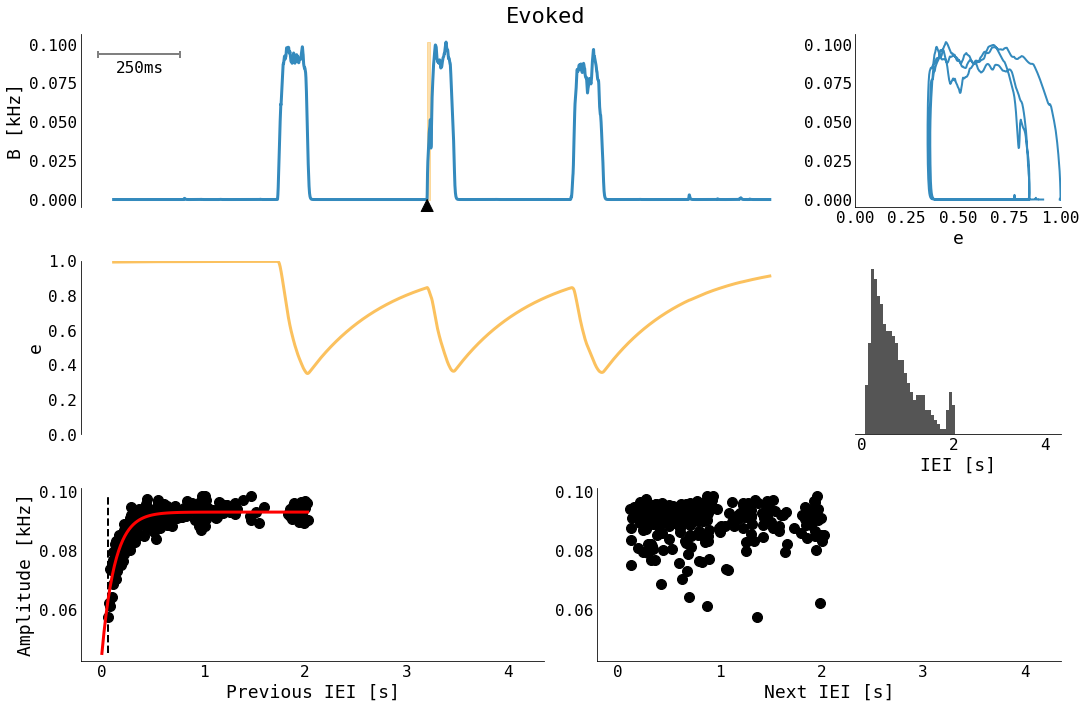

In [50]:
# simulate 10 minutes
res, stim_times, noise = simulate_hc_evoked(
    duration=600,
    pulse_amp=150.0,
    pulse_period=2000.0,
    pulse_duration=10.0,
    backend="numba",
)

res_full = res.copy()

peaks, iei, amps, fwhms = detect_peaks(
    res.sel({"output": "r_mean_INH"}).squeeze().values, res.time.values
)

# find evoked peaks
peaks_s = peaks * SAMPLING_DT * 1e-3
stims = np.array(stim_times) * DT * 1e-3

evoked_peaks = []
for i in range(stims.size):
    for j in range(peaks_s.size):
        if (peaks_s[j] > stims[i]) and (peaks_s[j] <= stims[i] + 0.1):
            evoked_peaks.append(j)
evoked_peaks = np.array(evoked_peaks)
if evoked_peaks[-1] == peaks_s.size - 1:
    evoked_peaks = evoked_peaks[:-1]

iei_prev = iei[evoked_peaks - 1]
iei_next = iei[evoked_peaks]
amps = amps[evoked_peaks]

# find 2 seconds with at least 3 peaks
rolling_sum_iei = np.cumsum(iei)
rolling_sum_iei[2:] = rolling_sum_iei[2:] - rolling_sum_iei[:-2]
rolling_sum_iei = rolling_sum_iei[1:]
at_least_3peaks = np.where(rolling_sum_iei < 1.8)[0][0]
mid_point = peaks[at_least_3peaks + 1] * SAMPLING_DT * 1e-3
res = res.sel({"time": slice(mid_point - 1.0, mid_point + 1.0)})
stims_plot = [
    stim for stim in stims if stim > mid_point - 1.0 and stim < mid_point + 1.0
]

plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 4)
cols = ["C1", "C4"]
fields = ["r_mean_INH", "e_SynDep"]
ylabels = ["B [kHz]", "e"]

for i in range(2):
    ax = plt.subplot(gs[i, :3])
    ax.plot(res.time, res.sel({"output": fields[i]}).T, color=cols[i], linewidth=3)
    ax.set_xticks([])
    ax.set_ylabel(ylabels[i])
    sns.despine(ax=ax, bottom=True)
    if i == 0:
        bar = AnchoredHScaleBar(
            size=0.25,
            label="250ms",
            loc=2,
            linekw=dict(color="gray", linewidth=2.0),
            ax=ax,
        )
        ax.add_artist(bar)
        # mark stimulation
        for stim in stims_plot:
            ax.fill_between(
                np.arange(stim, stim + 0.01, 0.00005),
                0,
                res.sel({"output": fields[i]}).max(),
                alpha=0.5,
                color="C4",
            )
            ax.annotate(
                "",
                xy=(stim, 0.0),
                xytext=(stim, -0.005),
                arrowprops=dict(facecolor="black"),
            )
    if i == 1:
        ax.set_ylim([0, 1])

# phase plane B-e
ax = plt.subplot(gs[0, -1])
ax.plot(
    res.sel({"output": "e_SynDep"}).T, res.sel({"output": "r_mean_INH"}).T, color=cols[0]
)
ax.set_xlim([0, 1])
ax.set_xlabel("e")
sns.despine(ax=ax)

# IEI
ax = plt.subplot(gs[1, -1])
ax.hist(iei, bins=30, fc="#555555")
sns.despine(ax=ax, left=True)
ax.set_yticks([])
ax.set_xlabel("IEI [s]")
ax.set_xlim(hist_xlims)

# SWR amp vs. IEI
ax = plt.subplot(gs[2, :2])
ax.plot(iei_prev, amps, "o", color="k")
# fit
fit_params, _ = curve_fit(
    fit_func, iei_prev, amps, p0=(2, 2, 68), bounds=(0, [100, 100, 100])
)
fit_iei = np.linspace(0, iei.max(), 100)
amps_fit = fit_func(fit_iei, *fit_params)
ax.plot(fit_iei, amps_fit, color="red", linewidth=3)
ax.vlines(iei.min(), amps_fit.min(), amps.max(), linestyles="--", color="k")
ax.set_xlabel("Previous IEI [s]")
ax.set_ylabel("Amplitude [kHz]")
sns.despine(ax=ax)
ax.set_xlim(fit_xlim)

ax = plt.subplot(gs[2, 2:], sharey=ax, sharex=ax)
ax.plot(iei_next, amps, "o", color="k")
ax.set_xlabel("Next IEI [s]")
sns.despine(ax=ax)
ax.set_xlim(fit_xlim)

plt.suptitle("Evoked")
plt.tight_layout()

plt.savefig("../figs/rate_evoked_SWR.pdf", transparent=True, bbox_inches="tight")

print(f"Found {len(peaks)} events in total")
print(f"Smallest IEI: {iei.min()*1000.:.1f}ms")
print(f"IEI: {np.mean(iei):.3f} +- {np.std(iei):.3f}s")
print(f"amplitudes: {np.mean(amps):.3f} +- {np.std(amps):.3f}kHz")
fwhms *= SAMPLING_DT
print(f"FWHM: {np.mean(fwhms):.3f} +- {np.std(fwhms):.3f}ms")
corr = pearsonr(iei_prev, amps)
print(f"Corr. amp. vs. previous IEI: {corr[0]:.3f} / p={corr[1]:.5f}")
corr = pearsonr(iei_next, amps)
print(f"Corr. amp. vs. next IEI: {corr[0]:.3f} / p={corr[1]:.5f}")
print(f"Time constant of fit: {1e3/fit_params[1]:.3f} ms")